In [50]:
%pip install -q tensorflow scikit-learn matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [51]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
# Parameters
CSV_PATH = 'BTC_Cleaned_Data.csv'  # relative path to your cleaned data file
WINDOW_SIZE = 7  # use 7 days -> predict next day
TRAIN_RATIO = 0.8  # chronological split: first 80% train, last 20% test
RANDOM_SEED = 42

df = pd.read_csv(CSV_PATH)


In [53]:
# Ensure a binary target exists. If not, create it as next-day Close > today Close (1 = up, 0 = down/equal)
if 'Target' not in df.columns:
    if 'Close' not in df.columns:
        raise ValueError('No `Target` or `Close` column found in the cleaned CSV. Please provide a target or include Close prices.')
    df = df.sort_values('Date').reset_index(drop=True) if 'Date' in df.columns else df.reset_index(drop=True)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    # drop last row which has no next-day target
    df = df.iloc[:-1].reset_index(drop=True)
    print('Created `Target` column using next-day Close comparison.')
else:
    print('Using existing `Target` column.')


Using existing `Target` column.


In [54]:
# Feature Selection: Focus on most informative features for price movement prediction
# We'll prioritize returns, spreads, and moving averages while excluding raw price/volume data

# Define priority features (engineered features that capture patterns)
priority_features = ['Daily_Return', 'High_Low_Spread', 'Close_Open_Spread', 'MA_7', 'MA_30']

# Check which priority features exist in the dataframe
exclude = ['date', 'Date', 'Target'] if ('date' in df.columns or 'Date' in df.columns) else ['Target']
available_cols = [c for c in df.columns if c not in exclude]

# Use priority features if available, otherwise fall back to all features except raw OHLC
selected_features = [f for f in priority_features if f in available_cols]
if not selected_features:
    # Fallback: exclude raw OHLC prices but keep engineered features
    selected_features = [c for c in available_cols if c not in ['open', 'Open', 'high', 'High', 'low', 'Low', 'close', 'Close']]

print(f'Selected {len(selected_features)} features from {len(available_cols)} available:')
print('Features used:', selected_features)
X_all = df[selected_features].values.astype(float)
y_all = df['Target'].values.astype(int)

Selected 5 features from 11 available:
Features used: ['Daily_Return', 'High_Low_Spread', 'Close_Open_Spread', 'MA_7', 'MA_30']


### Optional: PCA for Further Dimensionality Reduction
Uncomment the cell below if you want to apply PCA to reduce features to principal components. This can help if you still have too many features or want to remove multicollinearity.

In [55]:
# Optional: Apply PCA to reduce to top N components (uncomment to use)
# from sklearn.decomposition import PCA
# 
# # Apply PCA to capture 95% of variance
# pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
# X_all_pca = pca.fit_transform(X_all)
# print(f'Reduced from {X_all.shape[1]} to {X_all_pca.shape[1]} components')
# print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
# 
# # Replace X_all with PCA-transformed data
# X_all = X_all_pca

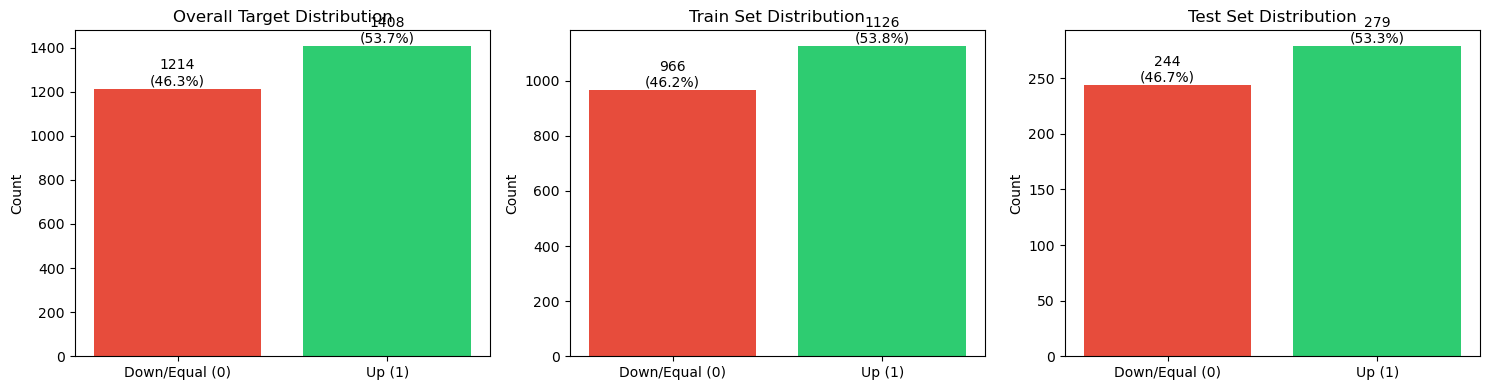


Class balance ratio (Up/Down): 1.160


In [56]:
# Plot class distribution to check for imbalance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall class distribution
unique, counts = np.unique(y_all, return_counts=True)
axes[0].bar(['Down/Equal (0)', 'Up (1)'], counts, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Target Distribution')
for i, (label, count) in enumerate(zip(['Down/Equal (0)', 'Up (1)'], counts)):
    axes[0].text(i, count, f'{count}\n({count/len(y_all)*100:.1f}%)', ha='center', va='bottom')

# Train set distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[1].bar(['Down/Equal (0)', 'Up (1)'], counts_train, color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Count')
axes[1].set_title('Train Set Distribution')
for i, (label, count) in enumerate(zip(['Down/Equal (0)', 'Up (1)'], counts_train)):
    axes[1].text(i, count, f'{count}\n({count/len(y_train)*100:.1f}%)', ha='center', va='bottom')

# Test set distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(['Down/Equal (0)', 'Up (1)'], counts_test, color=['#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Distribution')
for i, (label, count) in enumerate(zip(['Down/Equal (0)', 'Up (1)'], counts_test)):
    axes[2].text(i, count, f'{count}\n({count/len(y_test)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f'\nClass balance ratio (Up/Down): {counts[1]/counts[0]:.3f}')

In [57]:
# Sequence creation (sliding windows)
def create_sequences(X, y, window_size):
    Xs = []
    ys = []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)
# Create windows
X_seq, y_seq = create_sequences(X_all, y_all, WINDOW_SIZE)
print('Sequence shapes: X', X_seq.shape, 'y', y_seq.shape)


Sequence shapes: X (2615, 7, 5) y (2615,)


In [58]:
# Chronological train-test split (no random shuffling)
n_samples = len(X_seq)
split_idx = int(n_samples * TRAIN_RATIO)
X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test = X_seq[split_idx:]
y_test = y_seq[split_idx:]
print('Train samples:', len(X_train), 'Test samples:', len(X_test))

Train samples: 2092 Test samples: 523


In [59]:
# Scaling: fit MinMaxScaler on training data only. We reshape to combine windows so scaler sees the same features across time windows.
n_features = X_train.shape[2]
scaler = MinMaxScaler(feature_range=(0, 1))
# reshape (num_train_samples * window_size, n_features)
X_train_reshaped = X_train.reshape(-1, n_features)
scaler.fit(X_train_reshaped)
# transform train and test
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)
# Flatten sequences for Dense NN: shape -> (num_samples, window_size * n_features)
X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
X_test_flat = X_test_scaled.reshape(len(X_test_scaled), -1)
print('After scaling and flattening:', X_train_flat.shape, X_test_flat.shape)


After scaling and flattening: (2092, 35) (523, 35)


In [60]:
# Build Revised Dense neural network (architecture: 128 -> 64 -> 32 with BatchNormalization)
input_dim = X_train_flat.shape[1]
def build_revised_model(input_dim, lr=1e-3, dropout_rate=0.3):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = build_revised_model(input_dim)
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,745 (61.50 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [61]:
# Train the model with class weights to handle potential imbalance
# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print('Class weights:', class_weights)

# EarlyStopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_flat, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[es],
    shuffle=False,
    verbose=2
)

Class weights: {0: 1.0828157349896481, 1: 0.9289520426287744}
Epoch 1/100
Epoch 1/100
30/30 - 1s - 34ms/step - accuracy: 0.4899 - auc: 0.4968 - loss: 0.8632 - val_accuracy: 0.4476 - val_auc: 0.5314 - val_loss: 0.6962
Epoch 2/100
30/30 - 1s - 34ms/step - accuracy: 0.4899 - auc: 0.4968 - loss: 0.8632 - val_accuracy: 0.4476 - val_auc: 0.5314 - val_loss: 0.6962
Epoch 2/100
30/30 - 0s - 2ms/step - accuracy: 0.5303 - auc: 0.5433 - loss: 0.7753 - val_accuracy: 0.4476 - val_auc: 0.5309 - val_loss: 0.7004
Epoch 3/100
30/30 - 0s - 2ms/step - accuracy: 0.5303 - auc: 0.5433 - loss: 0.7753 - val_accuracy: 0.4476 - val_auc: 0.5309 - val_loss: 0.7004
Epoch 3/100
30/30 - 0s - 4ms/step - accuracy: 0.5234 - auc: 0.5391 - loss: 0.7625 - val_accuracy: 0.4476 - val_auc: 0.5051 - val_loss: 0.6988
Epoch 4/100
30/30 - 0s - 4ms/step - accuracy: 0.5234 - auc: 0.5391 - loss: 0.7625 - val_accuracy: 0.4476 - val_auc: 0.5051 - val_loss: 0.6988
Epoch 4/100
30/30 - 0s - 2ms/step - accuracy: 0.5165 - auc: 0.5208 - los

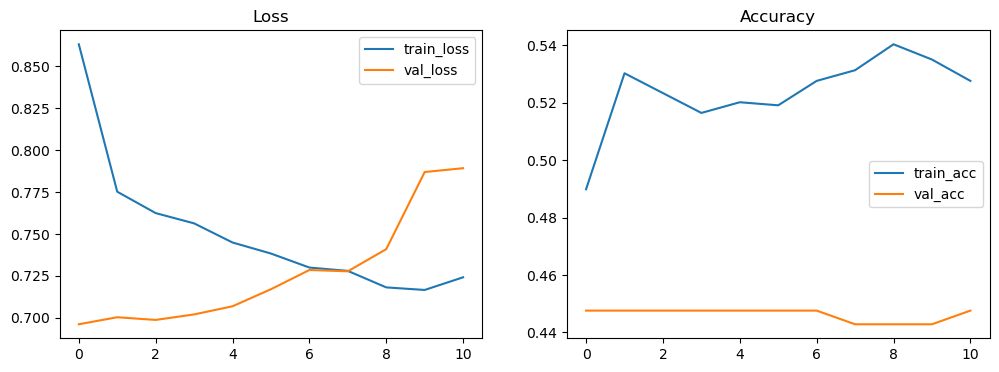

In [62]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [63]:
# Evaluate on test set
results = model.evaluate(X_test_flat, y_test, verbose=0)
print('Test loss, Test accuracy, Test AUC:', results)


Test loss, Test accuracy, Test AUC: [0.7284995317459106, 0.466539204120636, 0.5595363974571228]


In [64]:
# Save model (optional)
model.save('btc_dense_model.h5')
print('Saved model to btc_dense_model.h5')

Saved model to btc_dense_model.h5


## Next steps / Notes
- Consider hyperparameter tuning (learning rate, batch size, architecture).
- Try LSTM/GRU if you want the model to directly use sequential structure (no flattening).
- Use class weighting or resampling if the target class is imbalanced.
- To reproduce results, ensure `Date` ordering in the CSV and set seeds for numpy and TF.